In [1]:
import os
import numpy as np
from pprint import pprint
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import tensorflow as tf
import coremltools as  ct
import onnx
import onnxruntime as ort

In [2]:
from u2net import U2NET
from image_reader import get_img, img2torchInput

In [3]:
print("PyTorch :" , torch.__version__)
print("Tensorflow:", tf.__version__)
print("CoreML:" , ct.__version__)
print("Onnx:", onnx.__version__)

PyTorch : 1.10.0
Tensorflow: 2.3.1
CoreML: 5.0
Onnx: 1.10.2


In [4]:
plt.rcParams["figure.figsize"] = 20, 9

In [5]:
## android (Tensorflow lite)

## Load PyTorch model
## pytorch -> Onnx
## Onnx -> Tensorflow
## Tensorflow -> TF-lite
## compare prediction value

In [20]:
torch_weight = "./weights/demo_torch_weight.pth"
onnx_weight_out = "./weights/android/model.onnx"
tf_weight_out = "./weights/android/tf" ## Folder
tflite_weight_out = "./weights/android/model.tflite"
tflite_quantization_weight_out = "./weights/android/model_quantization.tflite"

os.makedirs(os.path.dirname(onnx_weight_out), exist_ok=True)
os.makedirs(os.path.dirname(tf_weight_out), exist_ok=True)
os.makedirs(os.path.dirname(tflite_weight_out), exist_ok=True)
os.makedirs(os.path.dirname(tflite_quantization_weight_out), exist_ok=True)

## Get Input

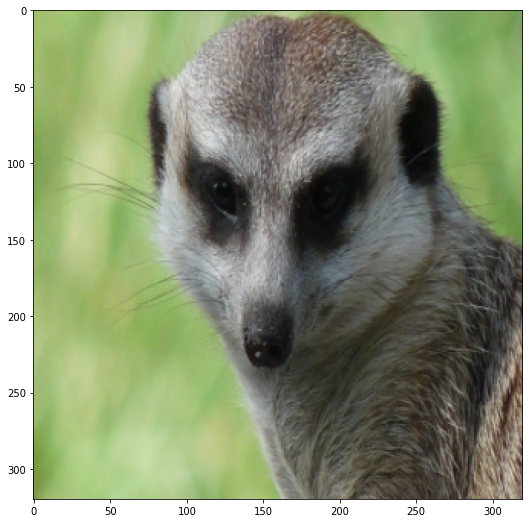

In [16]:
demo = get_img(7)
plt.imshow(demo)
x = img2torchInput(demo)
np_input = x.detach().numpy()

## Get Pytorch Model

In [8]:
model_pytorch = U2NET()
model_pytorch.load_state_dict(torch.load(torch_weight, map_location=torch.device("cpu")))
model_pytorch.eval()
pass

/Users/ckh/anaconda3/envs/cm/lib/python3.6/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/Users/ckh/anaconda3/envs/cm/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


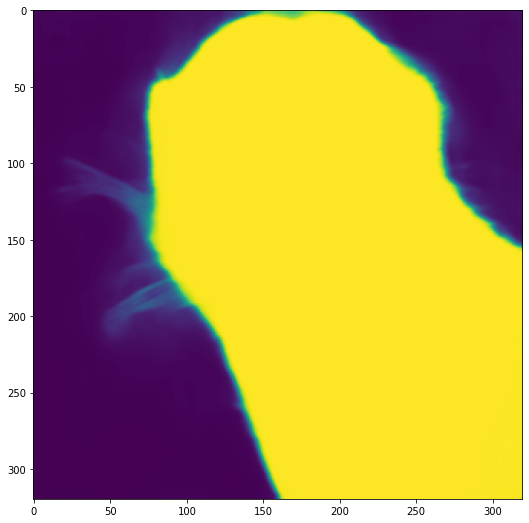

In [9]:
## pytroch inference
out_torch = model_pytorch(x)
mask_torch = out_torch[0].squeeze().detach().numpy()
plt.imshow(mask_torch)

## Torch -> Onnx

In [10]:
print(x.shape)
example_input = x
input_names = [ "input" ]
output_names = [ "output"]

torch.onnx.export(
    model_pytorch, example_input, onnx_weight_out, 
    verbose=False, opset_version=11,
    input_names=input_names, output_names=output_names)

torch.Size([1, 3, 320, 320])


In [11]:
## Load Onnx
model_onnx = onnx.load(onnx_weight_out)
onnx.checker.check_model(model_onnx)
# print(onnx.helper.printable_graph(model_onnx.graph))

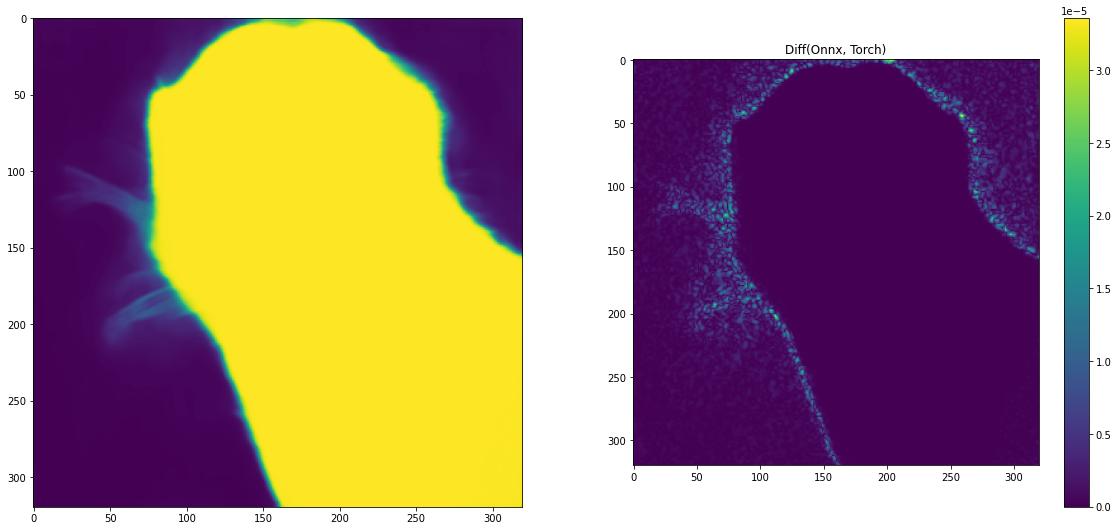

In [12]:
## Onnx - Inference
ort_session = ort.InferenceSession(onnx_weight_out)

outputs = ort_session.run(
    None,
    {"input": np_input},
)

mask_onnx = outputs[0][0][0]
plt.subplot(1,2,1)
plt.imshow(mask_onnx)
plt.subplot(1,2,2)
plt.imshow(np.abs(mask_onnx-mask_torch))
plt.title("Diff(Onnx, Torch)")
plt.colorbar()

## Onnx -> Tensorflow

In [13]:
from onnx_tf.backend import prepare

In [14]:
tf_rep = prepare(model_onnx) # prepare tf representation
tf_rep.export_graph(tf_weight_out)  # export the model

In [15]:
# load TF
model_tf = tf.saved_model.load(tf_weight_out)
print(list(model_tf.signatures.keys()))
tf_infer = model_tf.signatures["serving_default"]
print(tf_infer.structured_outputs.keys())

['serving_default']
dict_keys(['output'])


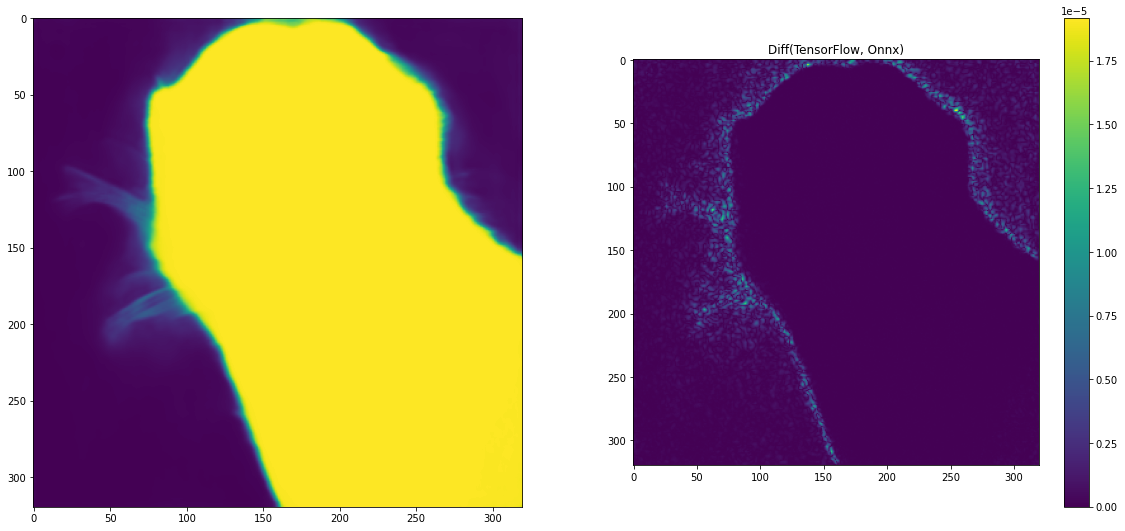

In [22]:
input_tf = tf.constant(np_input)
mask_tf = tf_infer(input_tf)['output'][0][0]

plt.subplot(1,2,1)
plt.imshow(mask_tf)
plt.subplot(1,2,2)
plt.imshow(np.abs(mask_tf-mask_onnx))
plt.title("Diff(TensorFlow, Onnx)")
plt.colorbar()

## Tensorflow -> Tf-lite

In [27]:
tflite_converter = tf.lite.TFLiteConverter.from_saved_model(tf_weight_out)
model_tflite = tflite_converter.convert()

# Save the model.
with open(tflite_weight_out, 'wb') as f:
  f.write(model_tflite)

INFO:absl:Using experimental converter: If you encountered a problem please file a bug. You can opt-out by setting experimental_new_converter=False


In [28]:
## Load TF-lite
loaded_tflite = tf.lite.Interpreter(tflite_weight_out)

AttributeError: 'Interpreter' object has no attribute 'get_signature_runner'

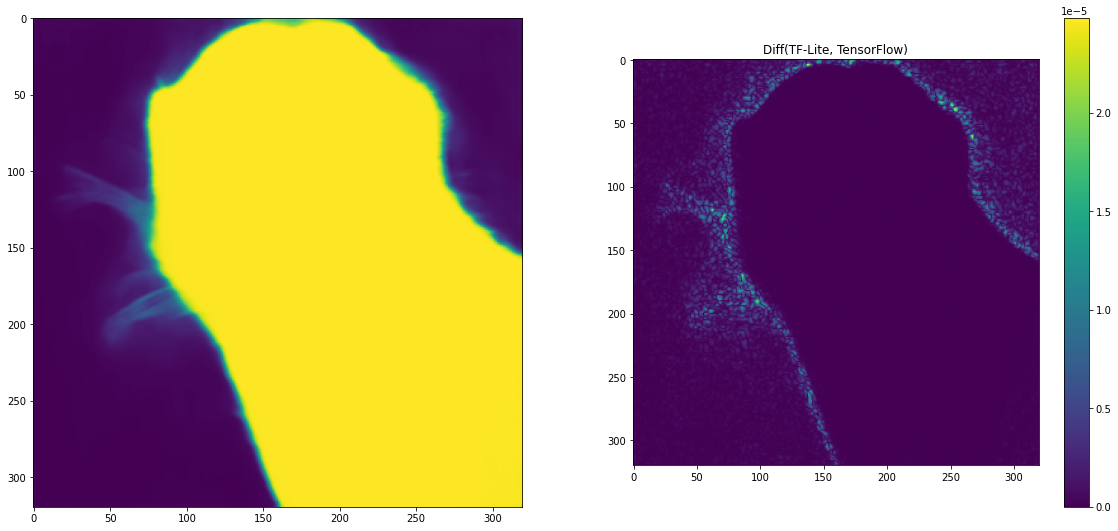

In [42]:
## TF-Lite - Infer

## Tensor Flow 2.5 and above
if tf.__version__ > '2.5':
    input_tf = tf.constant(np_input)
    tflite_signature = loaded_tflite.get_signature_runner()
    mask_tflite = tflite_signature(input=input_tf)['output'][0][0]
else:
    loaded_tflite.allocate_tensors()
    input_details = loaded_tflite.get_input_details()
    output_details = loaded_tflite.get_output_details()

    loaded_tflite.set_tensor(input_details[0]['index'], np_input)
    loaded_tflite.invoke()
    mask_tflite = loaded_tflite.get_tensor(output_details[0]['index'])[0][0]

plt.subplot(1,2,1)
plt.imshow(mask_tflite)
plt.subplot(1,2,2)
plt.imshow(np.abs(mask_tflite - mask_tf ))
plt.title("Diff(TF-Lite, TensorFlow)")
plt.colorbar()

## Tensorflow -> Tf-lite Quantization (16 bits)

In [43]:
tflite_converter_quan = tf.lite.TFLiteConverter.from_saved_model(tf_weight_out)
tflite_converter_quan.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_converter_quan.target_spec.supported_types = [tf.float16]
model_tflite_quan = tflite_converter_quan.convert()

# Save the model.
with open(tflite_quantization_weight_out, 'wb') as f:
  f.write(model_tflite_quan)

INFO:absl:Using experimental converter: If you encountered a problem please file a bug. You can opt-out by setting experimental_new_converter=False


In [44]:
## Load TF-lite
loaded_tflite_quan = tf.lite.Interpreter(tflite_quantization_weight_out)

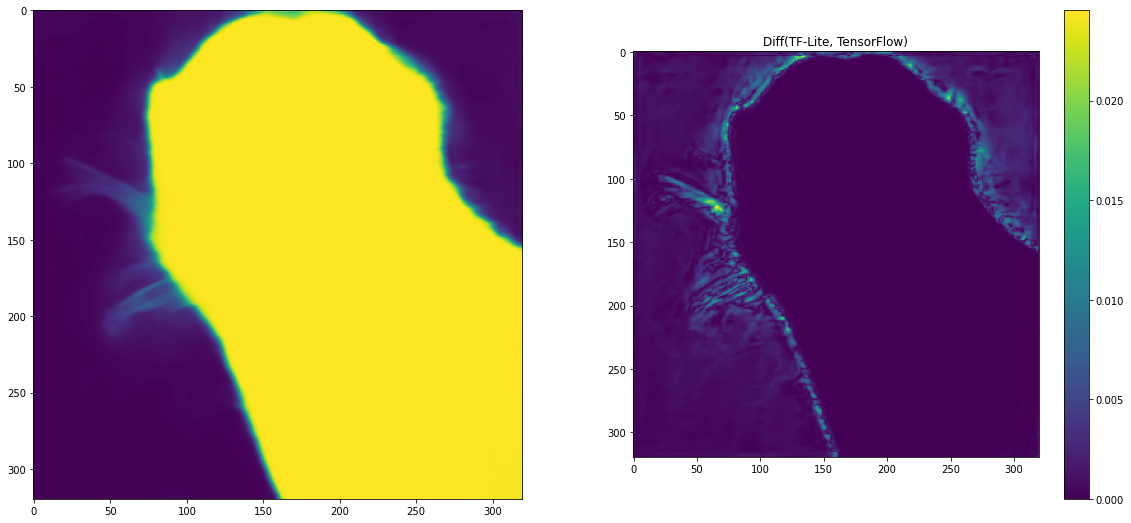

In [45]:
## TF-Lite - Infer

## Tensor Flow 2.5 and above
if tf.__version__ > '2.5':
    input_tf = tf.constant(np_input)
    tflite_signature = loaded_tflite_quan.get_signature_runner()
    mask_tflite_quan = tflite_signature(input=input_tf)['output'][0][0]
else:
    loaded_tflite_quan.allocate_tensors()
    input_details = loaded_tflite_quan.get_input_details()
    output_details = loaded_tflite_quan.get_output_details()

    loaded_tflite_quan.set_tensor(input_details[0]['index'], np_input)
    loaded_tflite_quan.invoke()
    mask_tflite_quan = loaded_tflite_quan.get_tensor(output_details[0]['index'])[0][0]

plt.subplot(1,2,1)
plt.imshow(mask_tflite_quan)
plt.subplot(1,2,2)
plt.imshow(np.abs(mask_tflite_quan - mask_tf))
plt.title("Diff(TF-Lite, TensorFlow)")
plt.colorbar()

## TF-lite Overview

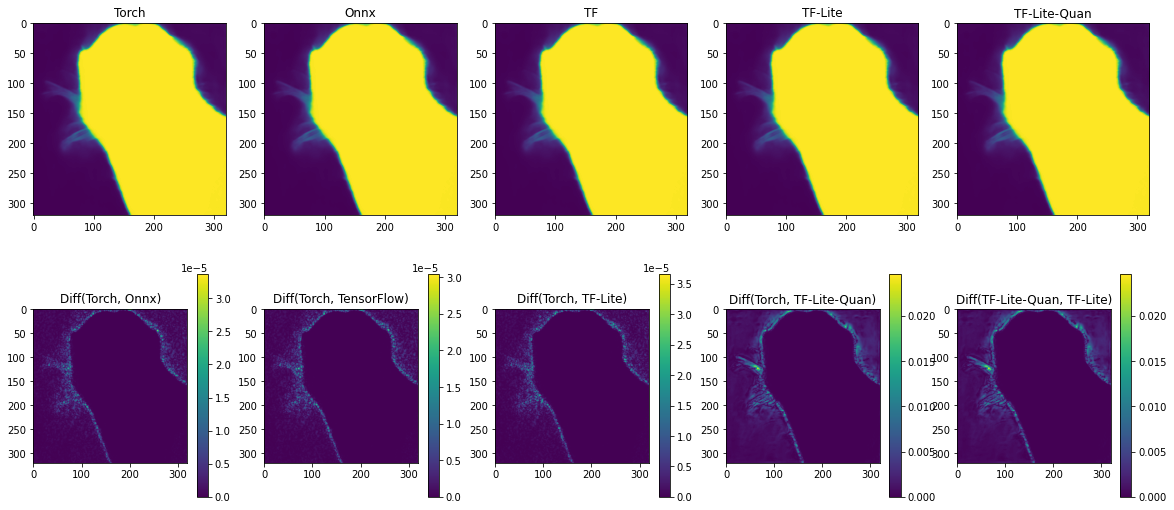

In [46]:
plt.subplot(2,5,1)
plt.imshow(mask_torch)
plt.title("Torch")

plt.subplot(2,5,2)
plt.imshow(mask_onnx)
plt.title("Onnx")

plt.subplot(2,5,3)
plt.imshow(mask_tf)
plt.title("TF")

plt.subplot(2,5,4)
plt.imshow(mask_tflite)
plt.title("TF-Lite")

plt.subplot(2,5,5)
plt.imshow(mask_tflite_quan)
plt.title("TF-Lite-Quan")

plt.subplot(2,5,6)
diff1 = np.abs(mask_torch - mask_onnx)
plt.imshow(diff1)
plt.title("Diff(Torch, Onnx)")
plt.colorbar()

plt.subplot(2,5,7)
diff2 = np.abs(mask_torch - mask_tf)
plt.imshow(diff2)
plt.title("Diff(Torch, TensorFlow)")
plt.colorbar()

plt.subplot(2,5,8)
diff3 = np.abs(mask_torch - mask_tflite)
plt.imshow(diff3)
plt.title("Diff(Torch, TF-Lite)")
plt.colorbar()

plt.subplot(2,5,9)
diff4 = np.abs(mask_torch - mask_tflite_quan)
plt.imshow(diff4)
plt.title("Diff(Torch, TF-Lite-Quan)")
plt.colorbar()

plt.subplot(2,5,10)
diff5 = np.abs(mask_tflite_quan - mask_tflite)
plt.imshow(diff5)
plt.title("Diff(TF-Lite-Quan, TF-Lite)")
plt.colorbar()

plt.savefig('./report/tflite.jpg')